### Farm Data Processing Project

#### Import Libraries

In [1]:
import random
import pandas as pd
import numpy as np

import re
import seaborn as sns

from matplotlib import pyplot as plt
from plotly import express as px
from scipy.stats import chi2_contingency, ttest_ind
from sqlalchemy import create_engine, text

import warnings
import logging
from datetime import datetime, timedelta

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None) 

#### Data Wrangling

In [2]:
def wrangling(path):
    # Read the data
    df = pd.read_csv(path)
    
    # Apply all cleaning operations
    df['crop_type'] = df['crop_type'].str.title().replace({'Soy': 'Soybeans'}).fillna('Unspecified Crop')
    df['soil_type'] = df['soil_type'].str.title().fillna('Unspecified Soil')
    df['irrigation_type'] = df['irrigation_type'].str.title().fillna('None')
    
    df['field_size_acres'] = df['field_size_acres'].abs()

    #df['yield_per_acre'] = df['yield_per_acre'].str.split(' ', expand = True)[2].astype(float).fillna(0)

    df['planting_date'] = pd.to_datetime(df['planting_date'], errors='coerce').dt.strftime('%Y-%m-%d')
    df['planting_date'] = pd.to_datetime(df['planting_date'])

    # Most plants survive between 15 and 30. For this project, we'll use 0 to 40
    df['temperature_celsius'] = df['temperature_celsius'].apply(lambda x: x if 0 <= x <= 40 else float('nan'))

    # PH values is between 0 and 14. Values outside this range are incorrect
    df['ph_level'] = df['ph_level'].apply(lambda x : x if x >= 0 and x <= 14 else float('nan'))
    
    df['pest_control'] = df['pest_control'].apply(lambda x : re.sub(r'L.*', '', str(x))).astype(float)

    df['fertilizer_used'] = df['fertilizer_used'].apply(lambda x : re.sub(r'k.*', '', str(x))).astype(float)

    
    return df
df = wrangling('varied_farm_data.csv')

#Populate field_id
def populate_field(df):
    field_ids = []
    
    for i in range(1, len(df) + 1):
        if i < 10:
            field = 'F00' + str(i)
        elif i < 100:
            field = 'F0' + str(i)
        else:
            field = 'F' + str(i)
        field_ids.append(field)
    
    return field_ids
df['field_id'] = populate_field(df)

In [3]:
df.head(10)

,field_id,region,season,crop_type,soil_type,field_size_acres,planting_date,temperature_celsius,rainfall_mm,yield_per_acre,ph_level,irrigation_type,fertilizer_used,pest_control
0,F001,West,Fall,Corn,Sandy Loam,105.753139,NaT,NaN,306.001900,72.661777,7.298133,Sprinkler,135.7,0.8
1,F002,Northeast,Winter,Corn,Clay Loam,69.373479,2023-12-24,10.786679,855.299595,NaN,7.271082,Drip,159.7,1.8
2,F003,Midwest,Winter,Unspecified Crop,Silt Loam,89.535571,2023-02-03,NaN,1230.015370,103.628245,7.499056,Drip,274.8,2.3
3,F004,South,Winter,Soybeans,Clay,NaN,2023-01-20,18.037213,972.868240,30.835988,7.683998,Sprinkler,168.6,1.8
4,F005,West,Spring,Wheat,Sandy Loam,101.411560,2023-03-18,NaN,443.958717,159.493012,6.249919,Sprinkler,139.5,1.6
5,F006,NaN,Fall,Corn,Sandy Loam,NaN,2023-10-21,22.016424,1032.585261,96.534691,7.021358,Sprinkler,108.2,0.5
6,F007,West,Spring,Wheat,Loamy Sand,150.655023,2023-04-25,31.110174,NaN,161.995225,7.114107,Sprinkler,125.0,2.5
7,F008,South,NaN,Corn,Sandy Loam,42.137476,2023-06-08,31.522530,813.402341,24.908853,6.430563,Sprinkler,146.6,1.6
8,F009,South,Summer,Corn,Clay,89.682257,2023-06-12,25.853866,891.109580,16.270057,6.357082,Sprinkler,170.3,2.4
9,F010,Midwest,Spring,Corn,Silt Loam,89.320668,2023-05-01,27.965398,NaN,385.246773,6.790392,Sprinkler,188.1,1.7


In [4]:
df.describe()[1:]

,field_size_acres,planting_date,temperature_celsius,rainfall_mm,yield_per_acre,ph_level,fertilizer_used,pest_control
mean,88.455513,2023-06-28 20:35:54.696132864,21.862903,818.982811,128.422868,6.561211,200.463986,1.503911
min,20.030075,2023-01-01 00:00:00,0.029859,194.855651,12.067029,5.500116,100.000000,0.500000
25%,55.493794,2023-03-27 00:00:00,16.448845,615.953364,47.173121,6.068598,150.500000,1.000000
50%,78.657587,2023-06-26 00:00:00,22.213703,813.521380,92.325193,6.556556,201.000000,1.500000
75%,115.449768,2023-09-27 00:00:00,27.745516,1011.206912,170.724808,7.060134,249.900000,2.000000
max,199.925064,2023-12-27 00:00:00,39.993641,1696.469408,502.242878,7.999531,300.000000,2.500000
std,42.261472,NaN,7.946487,276.606039,109.674539,0.595856,57.608923,0.580293


#### Exploratory Data Analysis

In [5]:
corr = df.select_dtypes("number").corr()
corr

,field_size_acres,temperature_celsius,rainfall_mm,yield_per_acre,ph_level,fertilizer_used,pest_control
field_size_acres,1.000000,0.147086,-0.389086,-0.073654,-0.032386,0.017602,-0.003272
temperature_celsius,0.147086,1.000000,-0.207796,-0.141496,0.036930,0.017317,0.002964
rainfall_mm,-0.389086,-0.207796,1.000000,0.248788,0.078636,-0.012781,-0.008528
yield_per_acre,-0.073654,-0.141496,0.248788,1.000000,-0.053850,-0.006831,0.000813
ph_level,-0.032386,0.036930,0.078636,-0.053850,1.000000,-0.002938,-0.005674
fertilizer_used,0.017602,0.017317,-0.012781,-0.006831,-0.002938,1.000000,0.008030
pest_control,-0.003272,0.002964,-0.008528,0.000813,-0.005674,0.008030,1.000000


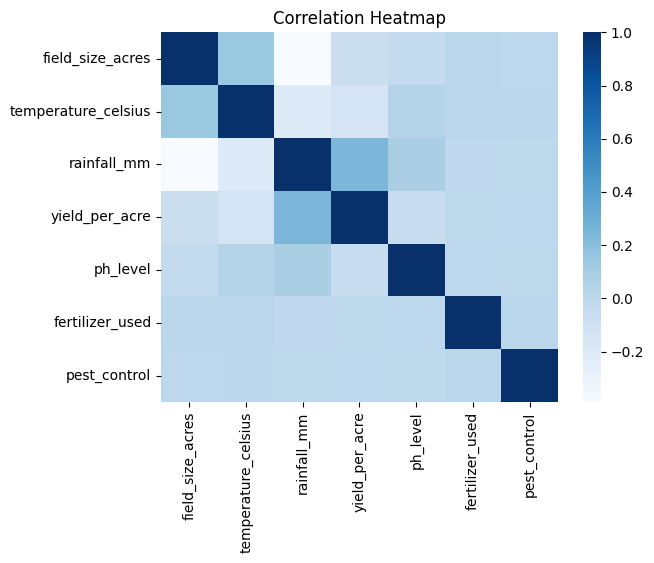

In [6]:
sns.heatmap(corr, cmap = 'Blues')
plt.title('Correlation Heatmap');

**Correlation Interpretation:**
   
   - Field size shows a weak positive correlation with temperature (0.147), suggesting a slight tendency for larger fields to be associated with higher temperatures.
   - Field size has a moderate negative correlation with rainfall (-0.389), indicating that larger fields might receive slightly less rainfall)**:
   - Temperature has a weak negative correlation with rainfall (-0.208), suggesting that as temperatures rise, rainfall might slightly decrease.
   - Temperature also shows a weak negative correlation with yield per acre (-0.141), indicating that higher temperatures might slightly reduce yield, though the effect iall (mm)**:
   - Rainfall has a moderate positive correlation with yield per acre (0.249), which suggests that more rainfall is somewhat associated with hiproductivity in this dataset.

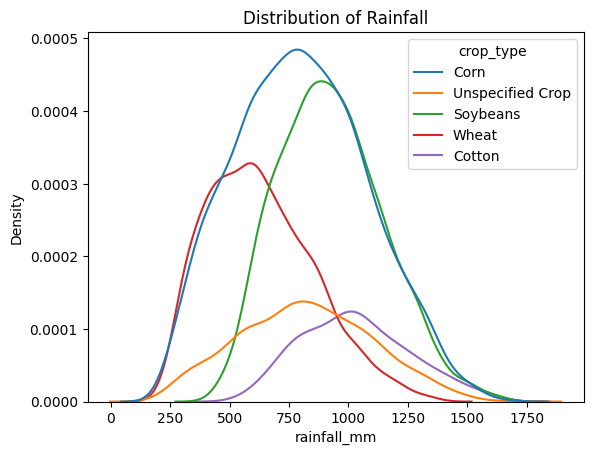

In [7]:
sns.kdeplot(data=df, x='rainfall_mm', hue='crop_type')
plt.title("Distribution of Rainfall");

This KDE plot shows the distribution of rainfall (in millimeters) across different crop types:
- All crops show a roughly normal distribution of rainfall
- Corn and Soybeans have very similar rainfall distributions with the highest peaks around 750-800mm
- Wheat has a lower peak of 550 but similar distribution shape
- Cotton has the highest peak around 1000 mm but with a smaller density
- All crops show high variabiity
This means that there are less fields planting Cotton at its peak rainfall than other crops

The high variability for all crops mean that each crop can adapt to a broad range of rainfall conditions. 
i.e. although each crop has an ideal peak rainfall, we can explore some other viable regions where rainfall varies significantly from their optimal level

<Axes: xlabel='season', ylabel='rainfall_mm'>

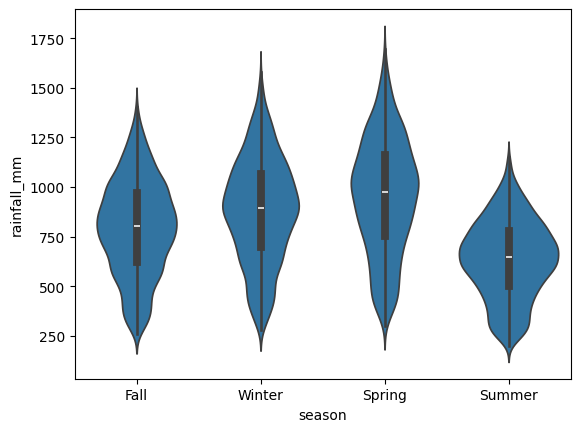

In [8]:
sns.violinplot(data=df, y='rainfall_mm', x='season')

**Interpretation**
- **Fall**: Rainfall mostly varies between 250 and 1300 mm, with a peak near 750mm
- **Winter**: Rainfall ranges from around 250 to 1500 mm, with a similar distribution shape to fall but slightly more concentrated near 800 mm.
- **Spring**: Rainfall has the widest range, from about 250 to 1700 mm, with peaks around 1000
- **Summer**: Rainfall is lower overall, ranging from 250 to 1000 mm, making it the driest season.

Spring and Fall have the highest and most variable rainfall, making them more favorable for water-dependent crops. Summer is relatively dry, so it might be less ideal for planting

In [9]:
season_report = df.groupby("season").agg(
    Farms_Count = ('field_id', 'count'), 
    Average_Yield = ('yield_per_acre', 'mean'),
    Average_Fertilizer = ('fertilizer_used', 'mean'),
    Average_Rainfall = ('rainfall_mm', 'mean')
    
)
print(season_report)

        Farms_Count  Average_Yield  Average_Fertilizer  Average_Rainfall
season                                                                  
Fall           3318     166.853295          200.291901        795.657839
Spring         3354     232.363577          201.803754        954.290554
Summer         3261      40.787110          200.771991        637.082683
Winter         3189      69.363497          199.269588        882.174612


**Interpretation:**
- Spring has the highest average yield and rainfall, suggesting that it is the most productive season.
- Summer has the lowest yield and rainfall, indicating lower productivity.
- Fertilizer usage is fairly consistent across all seasons, but it does not appear to correlate strongly with yield.

Efforts should be focused on maximizing productivity in Spring and Fall. For Summer, low yields could be linked to low rainfall, so irrigation might help in improving Summer yields

In [10]:
df_summer = df.query("season == 'Summer'")
summer_report = df_summer.groupby("irrigation_type").agg(
    Farms_Count = ('field_id', 'count'), 
    Average_Yield = ('yield_per_acre', 'mean'),
    Average_Fertilizer = ('fertilizer_used', 'mean')
    
)
print(summer_report)

                 Farms_Count  Average_Yield  Average_Fertilizer
irrigation_type                                                
Drip                     909      41.568929          198.973671
None                     413      45.846083          196.070400
Sprinkler               1939      39.329582          202.595184


**Recommendations (for Summer)**
- Reduce Sprinkler Use: Sprinklers have the lowest yield and use the most fertilizer.
- Consider Drip Irrigation: Drip irrigation gives better yield than sprinklers and uses less fertilizer.
- Study Non-Irrigated Farms: Farms without irrigation have the best yield with the least fertilizer. It may help to learn from their methods.

In [11]:
# Filter out rows with Unspecified values before creating crosstab
filtered_df = df[
    (~df['soil_type'].str.contains('Unspecified')) & 
    (~df['crop_type'].str.contains('Unspecified'))
]

# Create contingency table from filtered data
contingency_table = pd.crosstab(filtered_df['soil_type'], filtered_df['crop_type'])
print(contingency_table)

crop_type   Corn  Cotton  Soybeans  Wheat
soil_type                                
Clay         453     492       487      0
Clay Loam   1233       0      1222    514
Loamy Sand   735       0         0    751
Sandy Loam  1237     470       463    729
Silt Loam   1243       0      1187    498


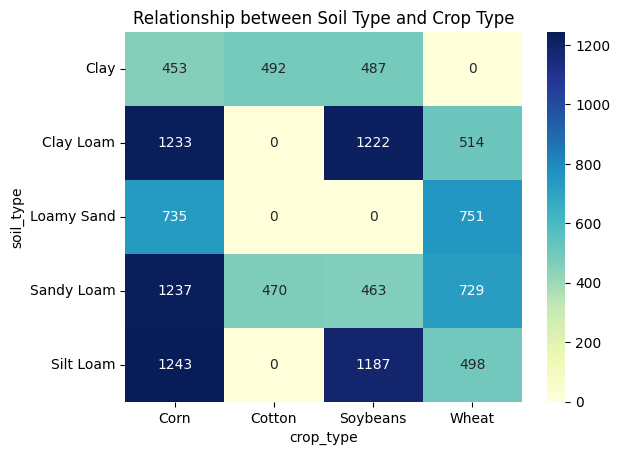

In [12]:
# Plotting the contingency table as a heatmap
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Relationship between Soil Type and Crop Type')
plt.show()

**Interpretation:**
- **Corn** grows best in **Sandy Loam** (1237), **Silt Loam** (1243), and **Clay Loam** (1233) but also appears in **Loamy Sand** (735) and **Clay** (453).
- **Cotton** is primarily found in **Clay** (492) and **Sandy Loam** (470)
- **Soybeans** thrive in **Clay Loam** (1222), **Silt Loam** (1187), **Clay** (487), and **Sandy Loam** (463).
- **Wheat** grows mainly in **Loamy Sand** (751), **Sandy Loam** (729), and **Clay Loam** (514), with no presence in **Clay**.

This means that **Sandy Loam** is generally used most for planting, while Cotton has specific soil preferences **(Sandy Loam and Clay)**

In [13]:
# Group by soil type and crop type, and calculate the average yield per acre (or other metric)
#avg_yield = df.groupby(['soil_type', 'crop_type'])['yield_per_acre'].mean()
avg_yield = filtered_df.groupby(['soil_type', 'crop_type'])['yield_per_acre'].mean()
avg_yield

soil_type   crop_type
Clay        Corn          61.405798
            Cotton        60.890803
            Soybeans      57.913697
Clay Loam   Corn         184.501264
            Soybeans     178.302981
            Wheat        205.166704
Loamy Sand  Corn          79.094116
            Wheat         80.589474
Sandy Loam  Corn          73.268832
            Cotton        61.745575
            Soybeans      58.823421
            Wheat         80.014202
Silt Loam   Corn         181.560407
            Soybeans     184.835001
            Wheat        206.436508
Name: yield_per_acre, dtype: float64

**Interpretation:**
- **Clay**: Corn, Cotton, and Soybeans have similar yields, around 58 to 61.
- **Clay Loam**: Higher yields for all crops, with Corn and Wheat having the highest, around 184 to 205.
- **Loamy Sand**: Moderate yields, with Corn and Wheat close to 79 and 80.
- **Sandy Loam**: Yields are a bit lower, with Corn, Cotton, and Soybeans around 58 to 73, and Wheat around 80.
- **Silt Loam**: High yields for Corn, Soybeans, and Wheat, around 181 to 206.

So, **Clay Loam and Silt Loam** give the highest average yields, especially for Wheat, while **Clay and Sandy Loam** have the lowest.

**Recommendation:** More crops should be planted using **Clay Loam and Silt Loam** 

#### Map Weather Station to Fields

In [14]:
mapping_df = pd.read_csv('farm_mapping.csv')
mapping_df.head()

,field_id,weather_station
0,11597,4
1,6413,1
2,5152,4
3,4730,1
4,3663,1


In [15]:
def populate_field2(df):
    field_ids = []
    
    for row in df.field_id:
        if row < 10:
            field = 'F00' + str(row)
        elif row < 100:
            field = 'F0' + str(row)
        else:
            field = 'F' + str(row)
        field_ids.append(field)
    
    return field_ids
mapping_df['field_id'] = populate_field2(mapping_df)
mapping_df.head()

,field_id,weather_station
0,F11597,4
1,F6413,1
2,F5152,4
3,F4730,1
4,F3663,1


In [16]:
df = df.merge(mapping_df[['field_id', 'weather_station']], on= 'field_id', how='left')
df.head()

,field_id,region,season,crop_type,soil_type,field_size_acres,planting_date,temperature_celsius,rainfall_mm,yield_per_acre,ph_level,irrigation_type,fertilizer_used,pest_control,weather_station
0,F001,West,Fall,Corn,Sandy Loam,105.753139,NaT,NaN,306.001900,72.661777,7.298133,Sprinkler,135.7,0.8,0
1,F002,Northeast,Winter,Corn,Clay Loam,69.373479,2023-12-24,10.786679,855.299595,NaN,7.271082,Drip,159.7,1.8,1
2,F003,Midwest,Winter,Unspecified Crop,Silt Loam,89.535571,2023-02-03,NaN,1230.015370,103.628245,7.499056,Drip,274.8,2.3,0
3,F004,South,Winter,Soybeans,Clay,NaN,2023-01-20,18.037213,972.868240,30.835988,7.683998,Sprinkler,168.6,1.8,2
4,F005,West,Spring,Wheat,Sandy Loam,101.411560,2023-03-18,NaN,443.958717,159.493012,6.249919,Sprinkler,139.5,1.6,4


#### Weather Messages

In [17]:
weather_messages_df = pd.read_csv("weather_message.csv")
weather_messages_df.head(5)

,Weather_station_ID,Message
0,4,"Station report 2023-11-25 07:03:24: Environmental temp at 1800.3C, continuing monitoring"
1,0,Environmental status 2022-08-06 20:24:34: AQI registered at 0.7
2,2,Rainfall intensity peaked at 0.359mm [2022-01-21 10:15:46]
3,4,Air quality snapshot: 1388.22 recorded at 2022-01-02 19:11:07
4,2,24-hour precipitation (2023-11-28 20:56:52): 786.12mm total accumulation


In [18]:
patterns = {
    'Temperature': r'(\d+(\.\d+)?)\s*?C',
    'Rainfall' : r'(\d+(\.\d+)?)\s*?mm',
    'Air Quality': r'(?:AQI registered at\s?|Air quality snapshot:\s?)(-?\d+(\.\d+)?)'
}

def extract_message(message):
    for key, pattern in patterns.items():
        match = re.search(pattern, message)

        if match:
            return key, float(next((x for x in match.groups() if x is not None)))

    return None, None

result = weather_messages_df['Message'].apply(extract_message)
weather_messages_df['Measurement'] = result.apply(lambda x : x[0])
weather_messages_df['Value'] = result.apply(lambda x : x[1])
weather_messages_df.head()



,Weather_station_ID,Message,Measurement,Value
0,4,"Station report 2023-11-25 07:03:24: Environmental temp at 1800.3C, continuing monitoring",Temperature,1800.300
1,0,Environmental status 2022-08-06 20:24:34: AQI registered at 0.7,Air Quality,0.700
2,2,Rainfall intensity peaked at 0.359mm [2022-01-21 10:15:46],Rainfall,0.359
3,4,Air quality snapshot: 1388.22 recorded at 2022-01-02 19:11:07,Air Quality,1388.220
4,2,24-hour precipitation (2023-11-28 20:56:52): 786.12mm total accumulation,Rainfall,786.120


### Data Pipelining

#### Data_Ingestion
**What we want to do?**
- Connect to Database
- Read Database File
- Read CSV Files
- Log Errors and Progress

In [19]:
import pandas as pd
from sqlalchemy import create_engine, text
import logging


logger = logging.getLogger('data_ingestion')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

def create_db_engine(dbpath):
    try:
        engine = create_engine(dbpath)
        with engine.connect() as conn:
            pass
        logger.info("Database Engine Created Successfully")
        return engine        
    except Exception :
        logger.error("SQLAlchemy is needed. Please import..")
    
def read_query(engine, query):
    try:
        with engine.connect() as conn:
            df = pd.read_sql(text(query), conn)
        logger.info("Database Read Successfully")
        return df
    except Exception as e:
        logger.error(f"Error: {e}")

def read_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        logger.info("File Read Successfully")
        return df
    except Exception:
        logger.error(f"{file_path} does not exist")

In [20]:
from data_imports import create_db_engine, read_query, read_csv

dbpath = "sqlite:///farm_dataset.db"
query = "SELECT * FROM farm_data"


engine = create_db_engine(dbpath)
df = read_query(engine, query)
weather_df = read_csv('farm_mapping.csv')
df.head()

2024-11-13 17:16:41,804 - data import - INFO - Database Engine Created Successfully
2024-11-13 17:16:42,011 - data import - INFO - Database Read Successfully
2024-11-13 17:16:42,046 - data import - INFO - File Read Successfully


,field_id,region,season,crop_type,soil_type,field_size_acres,planting_date,temperature_celsius,rainfall_mm,yield_per_acre,ph_level,irrigation_type,fertilizer_used,pest_control
0,F000,West,Fall,Corn,Sandy Loam,105.753139,None,NaN,306.001900,72.661777,7.298133,Sprinkler,135.7kg/ha,0.8L/ha
1,None,Northeast,Winter,Corn,Clay Loam,69.373479,2023-12-24,10.786679,855.299595,NaN,7.271082,Drip,159.7kg/ha,1.8L/ha
2,F002,Midwest,Winter,None,Silt Loam,89.535571,2023-02-03,NaN,1230.015370,103.628245,7.499056,Drip,274.8kg/ha,2.3L/ha
3,F003,South,Winter,Soybeans,Clay,NaN,2023-01-20,18.037213,972.868240,30.835988,7.683998,Sprinkler,168.6kg/ha,1.8L/ha
4,F004,West,Spring,Wheat,Sandy Loam,101.411560,2023-03-18,NaN,443.958717,159.493012,6.249919,Sprinkler,139.5kg/ha,1.6L/ha


#### Field Processor
**What we want to do?**
- Fix Spelling Errors in crop_type
- Fix Missing values in crop_type and soil_type with Unspecified, irrigation_type with None
- Return absolute values of field_size_acres
- planting_date to date
- Subset temperature_celsius and ph_level
- Remove unwanted characters in pest_control and fertilizer_used
- Map Fields to Weather stations
- Log Errors and Progress

Because there'll be a need to move the dataframe around, the Field Processor will be a class instead of methods

In [21]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from data_imports import create_db_engine, read_query, read_csv
import logging

logger = logging.getLogger("processing fields")
logging.basicConfig(level=logging.INFO, format = '%(asctime)s - %(name) - %(message)')

class ProcessFields:

    def __init__(self):
        self.df = None
        self.dbpath = "sqlite:///farm_dataset.db"
        self.query = "SELECT * FROM farm_data"
        self.absolute_column = 'field_size_acres'
        self.id_field = 'field_id'
        self.fill_columns = ['crop_type', 'soil_type', 'irrigation_type']
        self.values_to_rename = {'Soy': 'Soybeans'}
        self.columns_to_subset = ['temperature_celsius','ph_level', 'pest_control', 'fertilizer_used']
        self.date_to_fix = 'planting_date'

    def import_data(self):
        engine = create_db_engine(self.dbpath)
        self.df = read_query(engine, self.query)

        return self.df

    def correct_absolute_error(self):
        try:
            self.df[self.absolute_column] = self.df[self.absolute_column].abs()
            logger.info(f"{self.absolute_column} now contains positive values")        
            return self.df
    
        except Exception as e:
            logger.error(f"{self.absolute_column} is not numeric. Error: {e}")

    def populate_id(self):
        try:
            field_ids = []
            
            for i in range(1, len(self.df[self.id_field]) + 1):
                if i < 10:
                    field = 'F00' + str(i)
                elif i < 100:
                    field = 'F0' + str(i)
                else:
                    field = 'F' + str(i)
                field_ids.append(field)
        
            self.df[self.id_field] = field_ids
            logger.info(f'{self.id_field} values are now are in the expected format')
    
            return self.df
        except Exception as e:
            logger.error(f"Error: Column {e} does not exist")
    
    def fill_missing_values(self):
        for col in self.fill_columns:
            logger.info(f"Processing column: {col}")
            
            if col == 'crop_type':
                # Replacing values and filling missing ones
                original_values = self.df[col].isnull().sum()
                self.df[col] = self.df[col].str.title().replace(self.values_to_rename).fillna('Unspecified Crop')
                new_values = self.df[col].isnull().sum()
                logger.info(f"Filled missing values in '{col}'. Null count changed from {original_values} to {new_values}.")

            elif col == 'soil_type':
                # Handling 'soil_type' column
                original_values = self.df[col].isnull().sum()
                self.df[col] = self.df[col].str.title().fillna('Unspecified Soil')
                new_values = self.df[col].isnull().sum()
                logger.info(f"Filled missing values in '{col}'. Null count changed from {original_values} to {new_values}.")

            else:
                # Handling all other columns
                original_values = self.df[col].isnull().sum()
                self.df[col] = self.df[col].str.title().fillna('None')
                new_values = self.df[col].isnull().sum()
                logger.info(f"Filled missing values in '{col}'. Null count changed from {original_values} to {new_values}.")

        return self.df


    def subset_columns(self):
        for col in self.columns_to_subset:
            logger.info(f"Processing column: {col}")
            
            if col == 'temperature_celsius':
                original_values = self.df[col].isnull().sum()
                self.df[col] = self.df[col].apply(lambda x: x if 0 <= x <= 40 else np.nan)
                new_values = self.df[col].isnull().sum()
                logger.info(f"Temperature column '{col}' processed. Null count changed from {original_values} to {new_values}.")

            elif col == 'ph_level':
                original_values = self.df[col].isnull().sum()
                self.df[col] = self.df[col].apply(lambda x: x if 0 <= x <= 14 else np.nan)
                new_values = self.df[col].isnull().sum()
                logger.info(f"PH Level column '{col}' processed. Null count changed from {original_values} to {new_values}.")

            elif col == 'pest_control':
                original_values = self.df[col].isnull().sum()
                self.df[col] = self.df[col].apply(lambda x: re.sub(r'L.*', '', str(x)) if pd.notnull(x) else np.nan).astype(float).fillna(0)
                new_values = self.df[col].isnull().sum()
                logger.info(f"Pest Control column '{col}' processed. Null count changed from {original_values} to {new_values}.")

            else:
                original_values = self.df[col].isnull().sum()
                self.df[col] = self.df[col].apply(lambda x: re.sub(r'k.*', '', str(x)) if pd.notnull(x) else np.nan).astype(float).fillna(0)
                new_values = self.df[col].isnull().sum()
                logger.info(f"Other column '{col}' processed. Null count changed from {original_values} to {new_values}.")
                
        return self.df
        
    def fix_date(self):
        try:
            self.df[self.date_to_fix] = pd.to_datetime(self.df[self.date_to_fix], errors='coerce')
            logger.info("Date conversion successful for column: %s", self.date_to_fix)
            return self.df
            
        except Exception as e:
            logger.error("Failed to convert date for column %s: %s", self.date_to_fix, e)

    def map_weather_to_fields(self):
        # Code to map weather readings to corresponding fields
        weather_message = read_csv(self.weather_messages)
        self.df = self.df.merge(weather_message[['field_id', 'Weather_station_ID']], on = 'field_id', how = 'left')

        #df = df.merge(mapping_df[['field_id', 'weather_station']], on= 'field_id', how='left')
        
        return self.df


    def process_all(self):
        self.df = self.import_data()
        self.df = self.correct_absolute_error()
        self.df = self.populate_id()
        self.df = self.fill_missing_values()
        self.df = self.subset_columns()
        self.df = self.fix_date()
        self.df = self.map_weather_to_fields()

        return self.df

In [ ]:
from process_fields import ProcessFields

config = {
        'dbpath': "sqlite:///farm_dataset.db",
        'query': "SELECT * FROM farm_data",
        'absolute_column': 'field_size_acres',
        'id_field': 'field_id',
        'fill_columns': ['crop_type', 'soil_type', 'irrigation_type'],
        'values_to_rename': {'Soy': 'Soybeans'},
        'columns_to_subset': ['temperature_celsius', 'ph_level', 'pest_control', 'fertilizer_used'],
        'date_to_fix': 'planting_date',
        'weather_station_location' : 'farm_mapping.csv'
}
    

field_processing = ProcessFields(config)
field_df = field_processing.process_all()
field_df.head()

#### Weather Processor
**What we want to do?**
- Read map data and weather messages (csv's)
- Extract weather measurements and messages from weather station
- Log Errors and Progress

Because there'll be a need to move the dataframe around, the Field Processor will be a class instead of methods

In [23]:
import logging
import re
from process_fields import ProcessFields
from data_imports import read_csv


logger = logging.getLogger("WeatherFieldProcessor")
logging.basicConfig(level=logging.INFO, format = '%(asctime)s - %(name) - %(message)')
    
class WeatherFieldProcessor:
    
    def __init__(self, config):
        self.df = None
        self.weather_station_field = config['weather_station_location']
        self.weather_messages = config['weather_messages']
        self.id_field = config['id_field']
        self.patterns = config['patterns']
        
    def read_weather_and_field_data(self):
        # Code to read map data and weather messages (CSV files)
        self.df = read_csv(self.weather_messages)
        return self.df

     
    def extract_weather_measurements(self, message):
        for key, pattern in self.patterns.items():
            match = re.search(pattern, message)
    
            if match:
                return key, float(next((x for x in match.groups() if x is not None)))
            #logger.info("Weather Measurements Extracted")

        #logger.info("No pattern matched")
        return None, None

    
    def process_data(self):
        self.df = self.read_weather_and_field_data()       
        result = self.df['Message'].apply(self.extract_weather_measurements)
        self.df['Measurement'] = result.apply(lambda x : x[0])
        self.df['Value'] = result.apply(lambda x : x[1])

        logger.info("Weather Data Loaded Successfully!")

        return self.df


In [24]:
from process_weather import WeatherFieldProcessor

config = {
        'dbpath': "sqlite:///farm_dataset.db",
        'query': "SELECT * FROM farm_data",
        'absolute_column': 'field_size_acres',
        'id_field': 'field_id',
        'fill_columns': ['crop_type', 'soil_type', 'irrigation_type'],
        'values_to_rename': {'Soy': 'Soybeans'},
        'columns_to_subset': ['temperature_celsius', 'ph_level', 'pest_control', 'fertilizer_used'],
        'date_to_fix': 'planting_date',
        'weather_station_location' : 'farm_mapping.csv',
        'weather_messages' : 'weather_message.csv',
        'patterns' : {
                    'Temperature': r'(\d+(\.\d+)?)\s*?C',
                    'Rainfall' : r'(\d+(\.\d+)?)\s*?mm',
                    'Air Quality': r'(?:AQI registered at\s?|Air quality snapshot:\s?)(-?\d+(\.\d+)?)'
                    }
}

weather_processor = WeatherFieldProcessor(config)
weather_df = weather_processor.process_all()
weather_df.head()

2024-11-13 17:17:09,727 - data import - INFO - File Read Successfully
2024-11-13 17:17:10,339 - WeatherFieldProcessor - INFO - Weather Data Loaded Successfully!


,Weather_station_ID,Message,Measurement,Value
0,4,"Station report 2023-11-25 07:03:24: Environmental temp at 1800.3C, continuing monitoring",Temperature,1800.300
1,0,Environmental status 2022-08-06 20:24:34: AQI registered at 0.7,Air Quality,0.700
2,2,Rainfall intensity peaked at 0.359mm [2022-01-21 10:15:46],Rainfall,0.359
3,4,Air quality snapshot: 1388.22 recorded at 2022-01-02 19:11:07,Air Quality,1388.220
4,2,24-hour precipitation (2023-11-28 20:56:52): 786.12mm total accumulation,Rainfall,786.120


### Hypothesis Tests

#### Chi-Square Test of Independence

You can use a chi-square test of independence when you have two categorical variables. It allows you to test whether the two variables are related to each other. If two variables are independent (unrelated), the probability of belonging to a certain group of one variable isn't affected by the other variable.

**Source**: [Scribbr - Chi-Square Tests](https://www.scribbr.com/statistics/chi-square-tests/#:~:text=You%20can%20use%20a%20chi%2Dsquare%20test%20of%20independence%20when,affected%20by%20the%20other%20variable.)

**Hypothesis:**
- **Null Hypothesis:** There is no relationship between `soil_type` and `crop_type`
- **Alternate Hypothesis:** There is a relationship between`soil_type` and `crop_type`
 

In [25]:
config = {
        'dbpath': "sqlite:///farm_dataset.db",
        'query': "SELECT * FROM farm_data",
        'absolute_column': 'field_size_acres',
        'id_field': 'field_id',
        'fill_columns': ['crop_type', 'soil_type', 'irrigation_type'],
        'values_to_rename': {'Soy': 'Soybeans'},
        'columns_to_subset': ['temperature_celsius', 'ph_level', 'pest_control', 'fertilizer_used'],
        'columns_to_rename' : {'temperature_celsius' : 'Temperature', 'rainfall_mm' : 'Rainfall'},
        'date_to_fix': 'planting_date',
        'weather_station_location' : 'farm_mapping.csv',
        'weather_messages' : 'weather_message.csv',
        'patterns' : {
                    'Temperature': r'(\d+(\.\d+)?)\s*?C',
                    'Rainfall' : r'(\d+(\.\d+)?)\s*?mm',
                    'Air Quality': r'(?:AQI registered at\s?|Air quality snapshot:\s?)(-?\d+(\.\d+)?)'
                    }
}


In [26]:
import pandas as pd
from scipy.stats import chi2_contingency

#Load field_df
from process_fields import ProcessFields
processor = ProcessFields(config)
field_df = processor.process_all()
field_df.head()

2024-11-13 17:17:21,233 - data import - INFO - Database Engine Created Successfully
2024-11-13 17:17:21,511 - data import - INFO - Database Read Successfully
2024-11-13 17:17:21,523 - processing fields - INFO - field_size_acres now contains positive values
2024-11-13 17:17:21,536 - processing fields - INFO - field_id values are now are in the expected format
2024-11-13 17:17:21,536 - processing fields - INFO - Processing column: crop_type
2024-11-13 17:17:21,569 - processing fields - INFO - Filled missing values in 'crop_type'. Null count changed from 1474 to 0.
2024-11-13 17:17:21,569 - processing fields - INFO - Processing column: soil_type
2024-11-13 17:17:21,595 - processing fields - INFO - Filled missing values in 'soil_type'. Null count changed from 1486 to 0.
2024-11-13 17:17:21,595 - processing fields - INFO - Processing column: irrigation_type
2024-11-13 17:17:21,624 - processing fields - INFO - Filled missing values in 'irrigation_type'. Null count changed from 2342 to 0.
202

,field_id,region,season,crop_type,soil_type,field_size_acres,planting_date,Temperature,Rainfall,yield_per_acre,ph_level,irrigation_type,fertilizer_used,pest_control,weather_station
0,F001,West,Fall,Corn,Sandy Loam,105.753139,NaT,NaN,306.001900,72.661777,7.298133,Sprinkler,135.7,0.8,0
1,F002,Northeast,Winter,Corn,Clay Loam,69.373479,2023-12-24,10.786679,855.299595,NaN,7.271082,Drip,159.7,1.8,1
2,F003,Midwest,Winter,Unspecified Crop,Silt Loam,89.535571,2023-02-03,NaN,1230.015370,103.628245,7.499056,Drip,274.8,2.3,0
3,F004,South,Winter,Soybeans,Clay,NaN,2023-01-20,18.037213,972.868240,30.835988,7.683998,Sprinkler,168.6,1.8,2
4,F005,West,Spring,Wheat,Sandy Loam,101.411560,2023-03-18,NaN,443.958717,159.493012,6.249919,Sprinkler,139.5,1.6,4


In [27]:
def create_contigency_table(colA, colB):
    table = pd.crosstab(colA, colB)

    return table

contingency_table = create_contigency_table(field_df['soil_type'], field_df['crop_type'])
contingency_table

crop_type,Corn,Cotton,Soybeans,Unspecified Crop,Wheat
soil_type,,,,,
Clay,453,492,487,170,0
Clay Loam,1233,0,1222,329,514
Loamy Sand,735,0,0,161,751
Sandy Loam,1237,470,463,353,729
Silt Loam,1243,0,1187,305,498
Unspecified Soil,507,114,390,156,319


In [28]:
# Test is soil type and crop type are dependend on each other or not
def chi2_test(table):
    statistic, pvalue, dof, expected_freq = chi2_contingency(table)

    return statistic, pvalue

chi2, p_value = chi2_test(contingency_table)  #contingency_table = pd.crosstab(df['soil_type'], df['crop_type'])
print(f'Chi-square Statistic: {chi2:.2f}')
print(f'p-value: {p_value:.2f}')

Chi-square Statistic: 3947.97
p-value: 0.00


A **chi-square statistic** (3947.97) greater than **p-value** (0.0) suggests a strong association between `soil_type` and `crop_type`. 

This means the distribution of crop types across soil types is not random and that certain crop types are more likely to be associated with specific soil types.


We can conclude that there is strong evidence to reject the null hypothesis, which assumes there’s no relationship between `soil_type` and `crop_type`.

#### Calculates the T-test for the means of TWO INDEPENDENT samples of scores.
The two-sample t-test is a method used to test whether the unknown population means of two groups are equal or not

**Source**: [Two-Sample t-Test](https://www.jmp.com/en_sg/statistics-knowledge-portal/t-test/two-sample-t-test.html)

**Hypothesis:**
- **Null Hypothesis:** The measurements in field_df and weather_df are the same. H0: μ_field = μ_weather
- **Alternate Hypothesis:** The measurements in field_df and weather_df are not the same. H1: μ_field ≠ μ_weather.

In [29]:
from scipy.stats import ttest_ind

#Load weather_df
from process_weather import WeatherFieldProcessor
processor = WeatherFieldProcessor(config)
weather_df = processor.process_all()
weather_df.head()

2024-11-13 17:17:22,346 - data import - INFO - File Read Successfully
2024-11-13 17:17:22,942 - WeatherFieldProcessor - INFO - Weather Data Loaded Successfully!


,Weather_station_ID,Message,Measurement,Value
0,4,"Station report 2023-11-25 07:03:24: Environmental temp at 1800.3C, continuing monitoring",Temperature,1800.300
1,0,Environmental status 2022-08-06 20:24:34: AQI registered at 0.7,Air Quality,0.700
2,2,Rainfall intensity peaked at 0.359mm [2022-01-21 10:15:46],Rainfall,0.359
3,4,Air quality snapshot: 1388.22 recorded at 2022-01-02 19:11:07,Air Quality,1388.220
4,2,24-hour precipitation (2023-11-28 20:56:52): 786.12mm total accumulation,Rainfall,786.120


In [30]:
# Subset Weather Data to measurements e.g Temperature
def read_weather_data(df, measurement, weather_station = 0):
    station_df = df[df['Weather_station_ID'] == weather_station]
    measurement = station_df[station_df['Measurement'] == measurement]['Value']
    return measurement

# Subset Field Data to measurements e.g Temperature
def read_field_value(df, measurement, weather_station = 0):
    station_df = df[df['weather_station'] == weather_station]
    measurement = station_df[measurement]
    return measurement

measurement = 'Rainfall'
field_values = read_field_value(field_df, measurement)
weather_values = read_weather_data(weather_df, measurement)
field_values

0         306.001900
2        1230.015370
5        1032.585261
7         813.402341
10       1136.529481
12        544.632203
20        913.173776
27       1053.864280
30        356.073991
40       1392.648818
47        498.342022
48        444.754050
50        700.533595
59       1342.006353
61       1099.507112
64        467.065661
69        517.182260
70       1123.814969
73        493.996658
79       1141.211987
89        590.804934
90        929.385687
93               NaN
97       1185.336897
104       758.132317
114      1006.880650
116       779.181708
120              NaN
129       898.193778
130       337.321968
135       477.808332
153       549.776327
157       907.067717
163       939.830144
165       508.712541
166       745.910777
173       304.346754
175       276.303800
184              NaN
186       551.406941
190              NaN
195       296.588170
199       855.537071
204       739.768644
209       427.086553
212       993.965847
216       544.721250
217       698

In [31]:
# Run Independent Hypothesis Test
def run_test(colA, colB):
    statistic, pvalue = ttest_ind(colA, colB, nan_policy='omit', equal_var=False, alternative='two-sided')

    return statistic, pvalue

In [32]:
statistic, pvalue = run_test(field_values, weather_values)
print(f'Test Statistic: {statistic:.2f}')
print(f'pvalue: {pvalue:.2f}')

Test Statistic: 16.37
pvalue: 0.00


In [33]:
def make_decision(measurement, pvalue, alpha = 0.05):
    if pvalue < alpha:
        decision = (
            f"Reject the null hypothesis: The result is statistically significant for {measurement} "
            f"with a p-value of {pvalue:.2f} at an alpha level of {alpha}. "
            
        )
    else:
        decision = (
            f"Fail to reject the null hypothesis: The result is not statistically significant for {measurement} "
            f"with a p-value of {pvalue:.2f} at an alpha level of {alpha}. \n"
            
        )
    
    return decision

In [34]:
make_decision(measurement, pvalue, alpha = 0.05)

'Reject the null hypothesis: The result is statistically significant for Rainfall with a p-value of 0.00 at an alpha level of 0.05. '

In [35]:
measurement_list = ["Temperature", "Rainfall"]
weather_stations = sorted(list(weather_df["Weather_station_ID"].unique()))

In [36]:
#Test All Stations and Measurements

In [37]:
def test_all_stations():
    for station in weather_stations:
        print(f'\nTest of Independence for station {station}')
    
        for measurement in measurement_list:

            field_values = read_field_value(field_df, measurement, station)
            weather_values = read_weather_data(weather_df, measurement, station)

            statistic, pvalue = run_test(field_values, weather_values)
            
            print(make_decision(measurement, pvalue, alpha = 0.05))

test_all_stations()


Test of Independence for station 0
Reject the null hypothesis: The result is statistically significant for Temperature with a p-value of 0.00 at an alpha level of 0.05. 
Reject the null hypothesis: The result is statistically significant for Rainfall with a p-value of 0.00 at an alpha level of 0.05. 

Test of Independence for station 1
Reject the null hypothesis: The result is statistically significant for Temperature with a p-value of 0.00 at an alpha level of 0.05. 
Reject the null hypothesis: The result is statistically significant for Rainfall with a p-value of 0.00 at an alpha level of 0.05. 

Test of Independence for station 2
Reject the null hypothesis: The result is statistically significant for Temperature with a p-value of 0.00 at an alpha level of 0.05. 
Reject the null hypothesis: The result is statistically significant for Rainfall with a p-value of 0.00 at an alpha level of 0.05. 

Test of Independence for station 3
Reject the null hypothesis: The result is statistically

**Conclusion:**
- Since the p-value is less than the alpha level, we reject the null hypothesis.
- This means that there is a statistically significant difference between the measurements in field_df and weather_df.
- So, we conclude that the mean measurements in field_df is not equal to the mean measurements in weather_df.

**Implication:**
- Measurement units methods may differ.
- Data quality or accuracy issues (e.g., non-original values).
- Different data sources (e.g., local sensors vs. regional stations).
- Data processing steps (e.g., cleaning, averaging).